In [1]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pypi-iarc-packages/
!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp -r /kaggle/input/pypi-iarc-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pypi-iarc-packages/
Processing /kaggle/input/pypi-iarc-packages/tabpfn-0.1.9-py3-none-any.whl


In [2]:
import numpy as np
import pandas as pd
import joblib
import optuna
from functools import partial

import xgboost as xgb
import lightgbm as lgb

# custom modules
from preproc import load_data,scale_data
#from calibration1 import calibrate_probs,optimize_calibration
from calibration2 import calibrate_probs,optimize_calibration

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def balanced_logloss_(y_pred, y_true, eps=1e-7):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2


def compute_overall_metric(oof_dfs:list) -> float:
    all_metrics = [
        balanced_logloss_(oof.pred_proba.values, oof.Class.values)
        for oof in oof_dfs
    ]
    return np.mean(all_metrics)


def calibrate_oof(oof_dfs, calib_params):
    oof_dfs_calibrated = list()
    
    for oof in oof_dfs:
        oof = oof.copy(deep=True)
        calib_p1 = calibrate_probs(
            oof.pred_proba.values,
            **calib_params
        )
        oof["pred_proba"] = calib_p1
        oof_dfs_calibrated.append(oof)
        
    return oof_dfs_calibrated

In [4]:
# notebook parameter

CALIBRATE_FIRST = False

***
# load data and predictions

### 1. `lgbm-gbrt`

In [5]:
models_m01 = joblib.load("/kaggle/input/iarc-lgbm-gbrt-bagging-balanced/models.pkl")
calib_params_m01 = joblib.load("/kaggle/input/iarc-lgbm-gbrt-bagging-balanced/calib_params.pkl")
oof_dfs_m01 = joblib.load("/kaggle/input/iarc-lgbm-gbrt-bagging-balanced/oof_dataframes.pkl")

In [6]:
compute_overall_metric(oof_dfs_m01)

0.24033928714260183

In [7]:
oof_dfs_calib_m01 = calibrate_oof(oof_dfs_m01, calib_params_m01)
compute_overall_metric(oof_dfs_calib_m01)

0.22139398049564257

In [8]:
%%time
train,test,input_cols = load_data()

predicted_probs = [
    model.predict(test[input_cols]) 
    for model in models_m01
]
predicted_probs = np.mean(predicted_probs, axis=0)

if CALIBRATE_FIRST:
    predicted_probs = calibrate_probs(predicted_probs, **calib_params_m01)
predicted_probs_m01 = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)

del train,test

CPU times: user 192 ms, sys: 12.6 ms, total: 205 ms
Wall time: 180 ms


### 2. `lgbm-linear`

In [9]:
models_m02 = joblib.load("/kaggle/input/iarc-lgbm-linear-bagging-balanced/models.pkl")
calib_params_m02 = joblib.load("/kaggle/input/iarc-lgbm-linear-bagging-balanced/calib_params.pkl")
oof_dfs_m02 = joblib.load("/kaggle/input/iarc-lgbm-linear-bagging-balanced/oof_dataframes.pkl")

In [10]:
compute_overall_metric(oof_dfs_m02)

0.23776284612591142

In [11]:
oof_dfs_calib_m02 = calibrate_oof(oof_dfs_m02, calib_params_m02)
compute_overall_metric(oof_dfs_calib_m02)

0.21870748528950434

In [12]:
%%time
train,test,input_cols = load_data()
train,test,scaler = scale_data(train, test, input_cols)

predicted_probs = [
    model.predict(test[input_cols])
    for model in models_m02
]
predicted_probs = np.mean(predicted_probs, axis=0)

if CALIBRATE_FIRST:
    predicted_probs = calibrate_probs(predicted_probs, **calib_params_m02)
predicted_probs_m02 = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)

del train,test,scaler

CPU times: user 222 ms, sys: 5.9 ms, total: 228 ms
Wall time: 181 ms


### 3. `catboost`

In [13]:
models_m03 = joblib.load("/kaggle/input/iarc-catboost-weight-balanced/models.pkl")
calib_params_m03 = joblib.load("/kaggle/input/iarc-catboost-weight-balanced/calib_params.pkl")
oof_dfs_m03 = joblib.load("/kaggle/input/iarc-catboost-weight-balanced/oof_dataframes.pkl")

In [14]:
compute_overall_metric(oof_dfs_m03)

0.2633244023340282

In [15]:
oof_dfs_calib_m03 = calibrate_oof(oof_dfs_m03, calib_params_m03)
compute_overall_metric(oof_dfs_calib_m03)

0.22835158860669114

In [16]:
%%time
train,test,input_cols = load_data()

predicted_probs = [
    model.predict(test[input_cols], prediction_type="Probability")[:,1]
    for model in models_m03
]
predicted_probs = np.mean(predicted_probs, axis=0)

if CALIBRATE_FIRST:
    predicted_probs = calibrate_probs(predicted_probs, **calib_params_m03)
predicted_probs_m03 = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)

del train,test

CPU times: user 314 ms, sys: 23 ms, total: 337 ms
Wall time: 323 ms


### 4. `tabpfn`

In [17]:
models_m04 = joblib.load("/kaggle/input/iarc-tabpfn/models.pkl")
calib_params_m04 = joblib.load("/kaggle/input/iarc-tabpfn/calib_params.pkl")
oof_dfs_m04 = joblib.load("/kaggle/input/iarc-tabpfn/oof_dataframes.pkl")

In [18]:
compute_overall_metric(oof_dfs_m04)

0.3900050155836857

In [19]:
oof_dfs_calib_m04 = calibrate_oof(oof_dfs_m04, calib_params_m04)
compute_overall_metric(oof_dfs_calib_m04)

0.28839025101520327

In [20]:
%%time
train,test,input_cols = load_data()
train,test,scaler = scale_data(train, test, input_cols, impute_only=True)

predicted_probs = [
    model.predict_proba(test[input_cols])[:,1] 
    for model in models_m04
]
predicted_probs = np.mean(predicted_probs, axis=0)

if CALIBRATE_FIRST:
    predicted_probs = calibrate_probs(predicted_probs, **calib_params_m04)
predicted_probs_m04 = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)

del train,test,scaler

CPU times: user 2min 51s, sys: 3.33 s, total: 2min 55s
Wall time: 1min 47s


### 5. `multiout-mlp`

In [21]:
models_m05 = joblib.load("/kaggle/input/iarc-multiout-tf-mlp/models.pkl")
calib_params_m05 = joblib.load("/kaggle/input/iarc-multiout-tf-mlp/calib_params.pkl")
oof_dfs_m05 = joblib.load("/kaggle/input/iarc-multiout-tf-mlp/oof_dataframes.pkl")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [22]:
compute_overall_metric(oof_dfs_m05)

0.30563847176445524

In [23]:
oof_dfs_calib_m05 = calibrate_oof(oof_dfs_m05, calib_params_m05)
compute_overall_metric(oof_dfs_calib_m05)

0.2904142458122567

In [24]:
%%time
train,test,input_cols = load_data()
train,test,scaler = scale_data(train, test, input_cols)

predicted_probs = [
    model.predict(test[input_cols].values, verbose=0)[0][:,1:].sum(axis=1)
    for model in models_m05
]
predicted_probs = np.mean(predicted_probs, axis=0)

if CALIBRATE_FIRST:
    predicted_probs = calibrate_probs(predicted_probs, **calib_params_m05)
predicted_probs_m05 = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)

del train,test,scaler

CPU times: user 7.81 s, sys: 119 ms, total: 7.93 s
Wall time: 8.08 s


### 6. `xgb-gblinear`

In [25]:
models_m06 = joblib.load("/kaggle/input/iarc-xgb-gblinear/models.pkl")
calib_params_m06 = joblib.load("/kaggle/input/iarc-xgb-gblinear/calib_params.pkl")
oof_dfs_m06 = joblib.load("/kaggle/input/iarc-xgb-gblinear/oof_dataframes.pkl")

[22:29:35] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[22:29:35] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[22:29:35] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, pl

In [26]:
compute_overall_metric(oof_dfs_m06)

0.37894304572238047

In [27]:
oof_dfs_calib_m06 = calibrate_oof(oof_dfs_m06, calib_params_m06)
compute_overall_metric(oof_dfs_calib_m06)

0.36502436920847003

In [28]:
%%time
train,test,input_cols = load_data()
train,test,scaler = scale_data(train, test, input_cols)

predicted_probs = [
    model.predict(xgb.DMatrix(test[input_cols]))
    for model in models_m06
]
predicted_probs = np.mean(predicted_probs, axis=0)

if CALIBRATE_FIRST:
    predicted_probs = calibrate_probs(predicted_probs, **calib_params_m06)
predicted_probs_m06 = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)

del train,test,scaler

CPU times: user 307 ms, sys: 5.94 ms, total: 313 ms
Wall time: 336 ms


### 7. xgb-gbtree

In [29]:
models_m07 = joblib.load("/kaggle/input/iarc-xgb-gbtree/models.pkl")
calib_params_m07 = joblib.load("/kaggle/input/iarc-xgb-gbtree/calib_params.pkl")
oof_dfs_m07 = joblib.load("/kaggle/input/iarc-xgb-gbtree/oof_dataframes.pkl")

[22:29:35] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[22:29:35] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[22:29:35] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, pl

In [30]:
compute_overall_metric(oof_dfs_m07)

0.27239995042577647

In [31]:
oof_dfs_calib_m07 = calibrate_oof(oof_dfs_m07, calib_params_m07)
compute_overall_metric(oof_dfs_calib_m07)

0.22564184381208174

In [32]:
%%time
train,test,ianput_cols = load_data()

predicted_probs = [
    model.predict(xgb.DMatrix(test[input_cols]))
    for model in models_m07
]
predicted_probs = np.mean(predicted_probs, axis=0)

if CALIBRATE_FIRST:
    predicted_probs = calibrate_probs(predicted_probs, **calib_params_m07)
predicted_probs_m07 = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)

del train,test

CPU times: user 297 ms, sys: 3.79 ms, total: 301 ms
Wall time: 303 ms


***
# stacking model training

In [33]:
# models to consider

if not CALIBRATE_FIRST:
    oof_all = [
        oof_dfs_m01,
        oof_dfs_m02,
        oof_dfs_m03,
        oof_dfs_m04,
        oof_dfs_m05,
        oof_dfs_m06,
        oof_dfs_m07,
    ]
else:
    oof_all = [
        oof_dfs_calib_m01,
        oof_dfs_calib_m02,
        oof_dfs_calib_m03,
        oof_dfs_calib_m04,
        oof_dfs_calib_m05,
        oof_dfs_calib_m06,
        oof_dfs_calib_m07,
    ]

In [34]:
train,test,input_cols = load_data()
train,test,scaler = scale_data(train, test, input_cols)

In [35]:
repeated_cv_split = joblib.load("/kaggle/input/iarc-data-split/repeated_5fold_cv_split_4validation.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


In [36]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [37]:
model_params = {
    'objective': 'binary',
    'linear_tree': True,
    'metric': 'None',
    'learning_rate': 0.005,
    'num_iterations': 1790,
    'early_stopping_round':-1,
    'max_bin': 31,
    'num_leaves': 31,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity': -1,

    'feature_fraction': 0.8500000000000001,
    'lambda_l1': 1.882514072161519e-07,
    'lambda_l2': 0.47310656156097364,
    'linear_lambda': 1.6136340709412249e-10,
    'min_data_in_leaf': 29,
    'min_gain_to_split': 1.2401743751214779e-05,
    'path_smooth': 7.124685345958355e-10,
    
    'bagging_freq': 1,
    'pos_bagging_fraction': 1,
    'neg_bagging_fraction': 0.21218074656188604,
}

In [38]:
def include_oof_preds(train, input_cols, oof_all, repeat_nbr):
    train = train.copy()
    input_cols = input_cols.tolist().copy()
    n_models = len(oof_all)
    
    for i in range(n_models):
        _oof = oof_all[i][repeat_nbr][["Id","pred_proba"]].rename({"pred_proba":f"pm{i+1}"}, axis=1)
        train = pd.merge(train, _oof)
        input_cols.append(f"pm{i+1}")
        
    return train,input_cols

In [48]:
def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

import matplotlib.pyplot as plt

REPEAT NUMBER: 1/10
training model for fold: 1/5
[100]	valid_0's balanced_logloss: 0.544706


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's balanced_logloss: 0.409256
[300]	valid_0's balanced_logloss: 0.349837
[400]	valid_0's balanced_logloss: 0.327383
[500]	valid_0's balanced_logloss: 0.321781
[600]	valid_0's balanced_logloss: 0.326369
[700]	valid_0's balanced_logloss: 0.33601
[800]	valid_0's balanced_logloss: 0.351951
[900]	valid_0's balanced_logloss: 0.3671
[1000]	valid_0's balanced_logloss: 0.38721
[1100]	valid_0's balanced_logloss: 0.404673
[1200]	valid_0's balanced_logloss: 0.425782
[1300]	valid_0's balanced_logloss: 0.448303
[1400]	valid_0's balanced_logloss: 0.470635
[1500]	valid_0's balanced_logloss: 0.488889
[1600]	valid_0's balanced_logloss: 0.503856
[1700]	valid_0's balanced_logloss: 0.522961


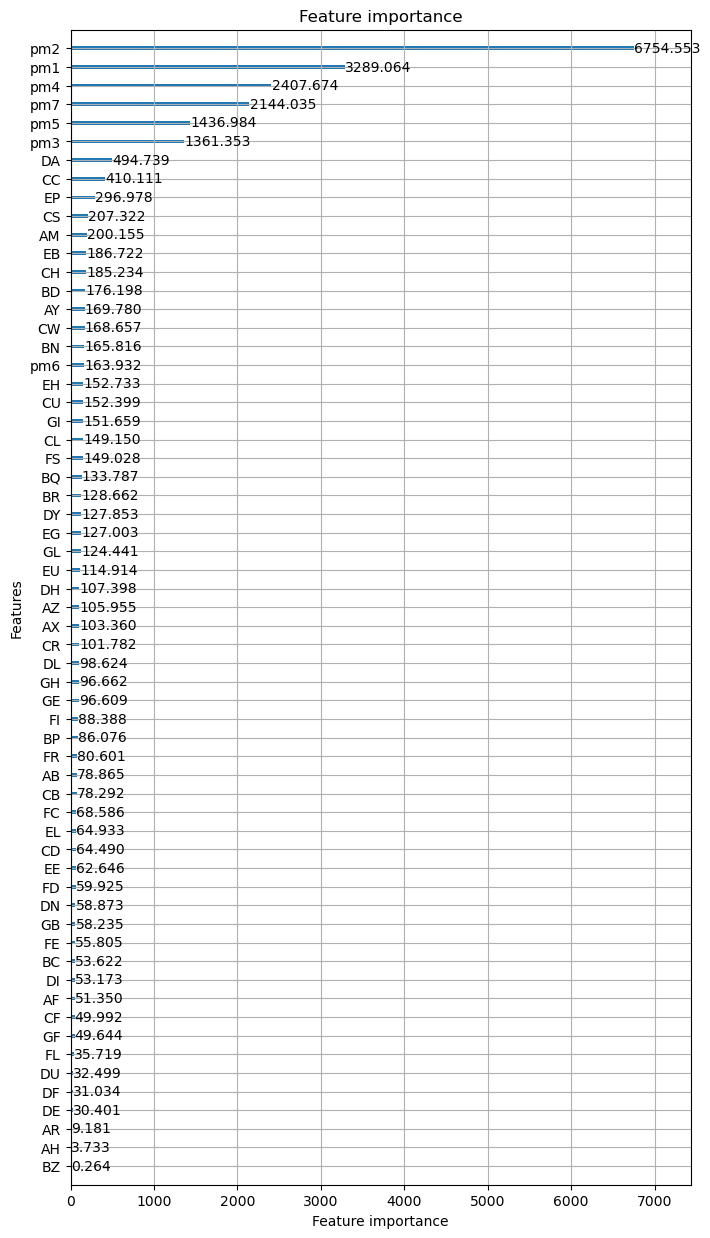

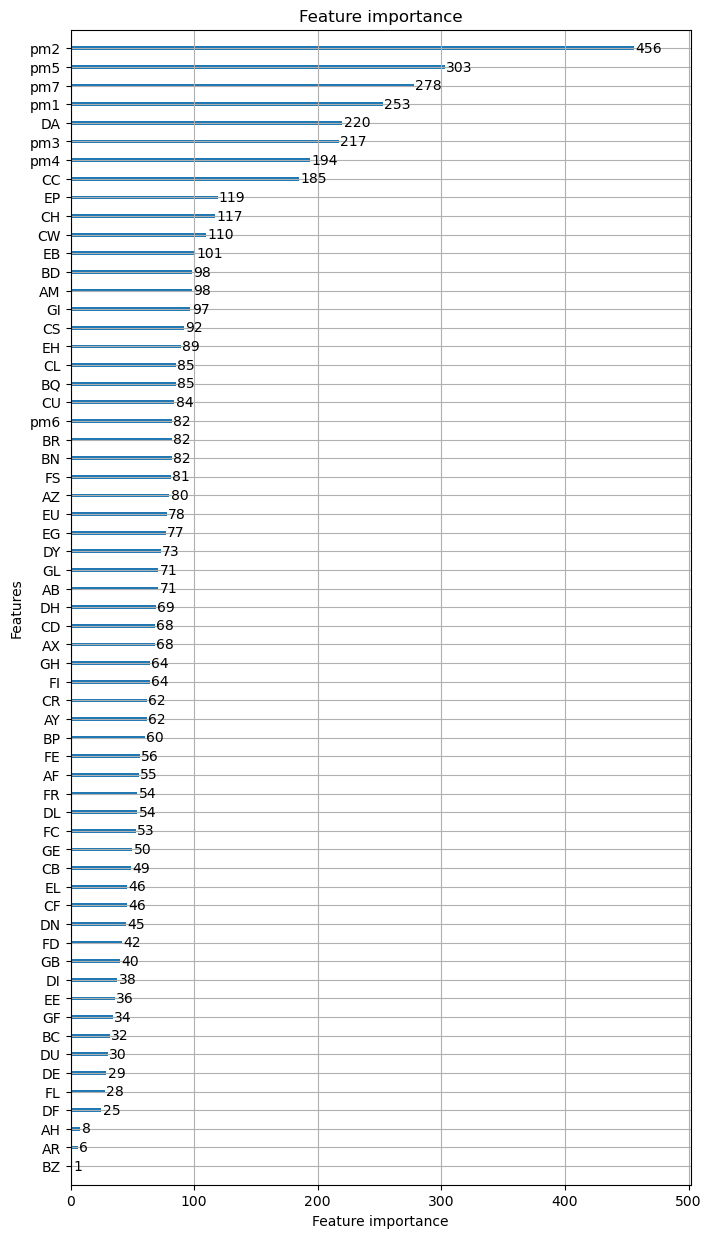

training model for fold: 2/5
[100]	valid_0's balanced_logloss: 0.497104


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's balanced_logloss: 0.362554
[300]	valid_0's balanced_logloss: 0.305243
[400]	valid_0's balanced_logloss: 0.282477
[500]	valid_0's balanced_logloss: 0.273296
[600]	valid_0's balanced_logloss: 0.27398
[700]	valid_0's balanced_logloss: 0.280204
[800]	valid_0's balanced_logloss: 0.284969
[900]	valid_0's balanced_logloss: 0.292965
[1000]	valid_0's balanced_logloss: 0.301438
[1100]	valid_0's balanced_logloss: 0.312021
[1200]	valid_0's balanced_logloss: 0.324239
[1300]	valid_0's balanced_logloss: 0.332993
[1400]	valid_0's balanced_logloss: 0.339848
[1500]	valid_0's balanced_logloss: 0.349797
[1600]	valid_0's balanced_logloss: 0.360444
[1700]	valid_0's balanced_logloss: 0.368547


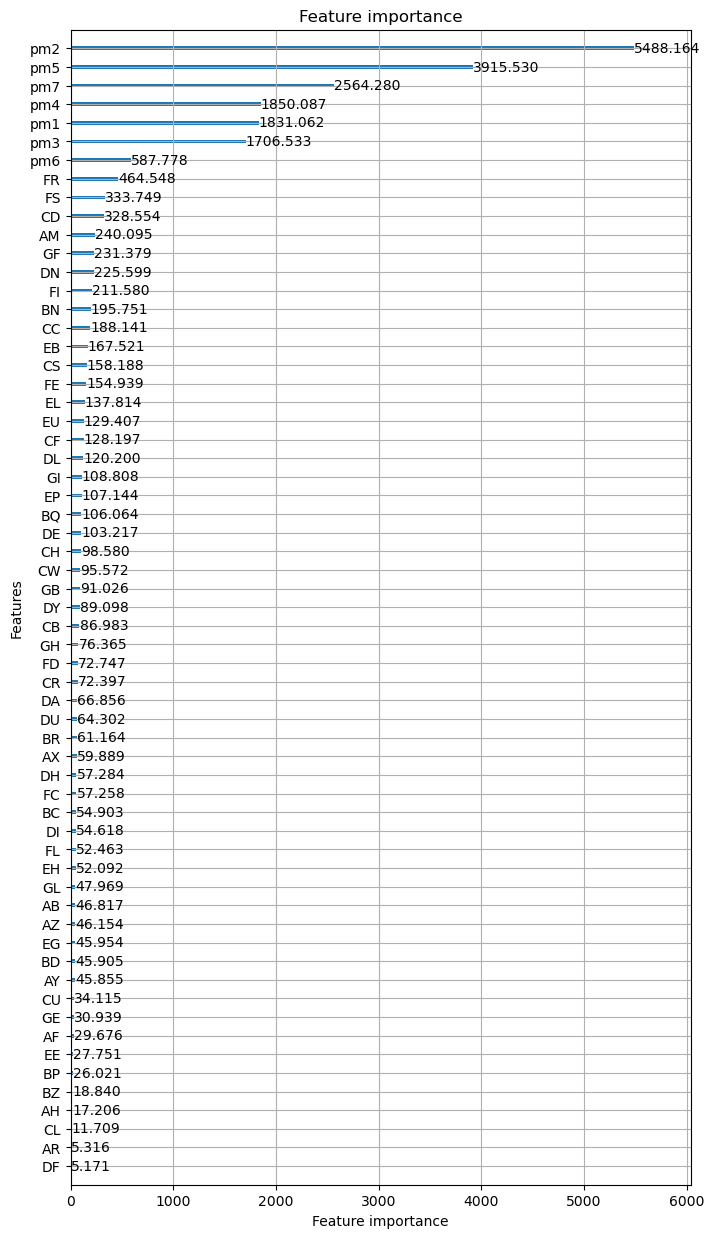

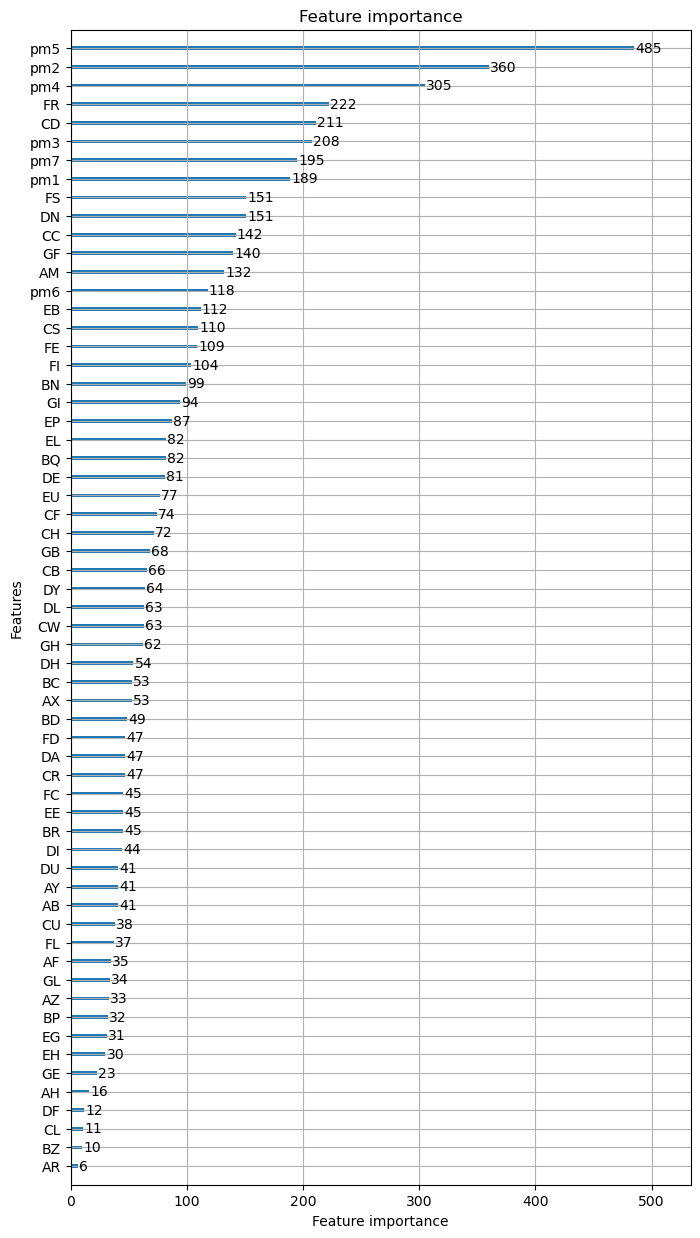

training model for fold: 3/5


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	valid_0's balanced_logloss: 0.479072
[200]	valid_0's balanced_logloss: 0.311714
[300]	valid_0's balanced_logloss: 0.230802
[400]	valid_0's balanced_logloss: 0.18457
[500]	valid_0's balanced_logloss: 0.159005
[600]	valid_0's balanced_logloss: 0.14444
[700]	valid_0's balanced_logloss: 0.134029
[800]	valid_0's balanced_logloss: 0.129201
[900]	valid_0's balanced_logloss: 0.125748
[1000]	valid_0's balanced_logloss: 0.124825
[1100]	valid_0's balanced_logloss: 0.12286
[1200]	valid_0's balanced_logloss: 0.123056
[1300]	valid_0's balanced_logloss: 0.124749
[1400]	valid_0's balanced_logloss: 0.126993
[1500]	valid_0's balanced_logloss: 0.126678
[1600]	valid_0's balanced_logloss: 0.130916
[1700]	valid_0's balanced_logloss: 0.136338


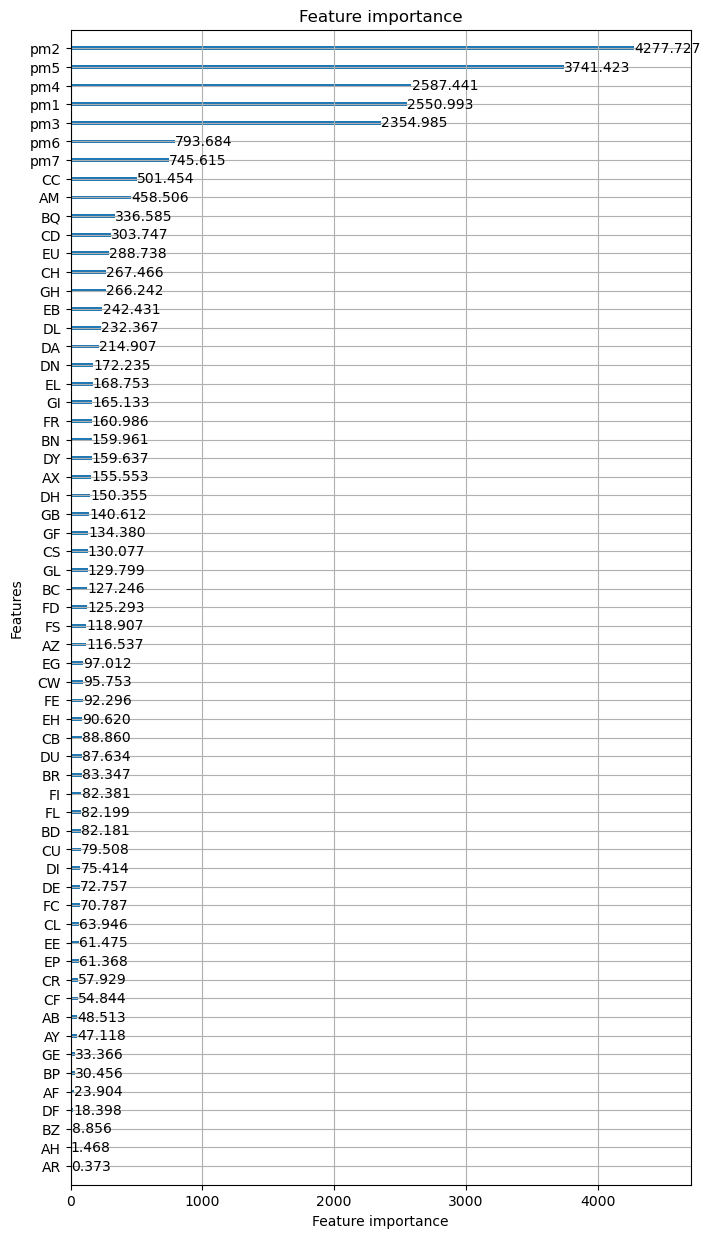

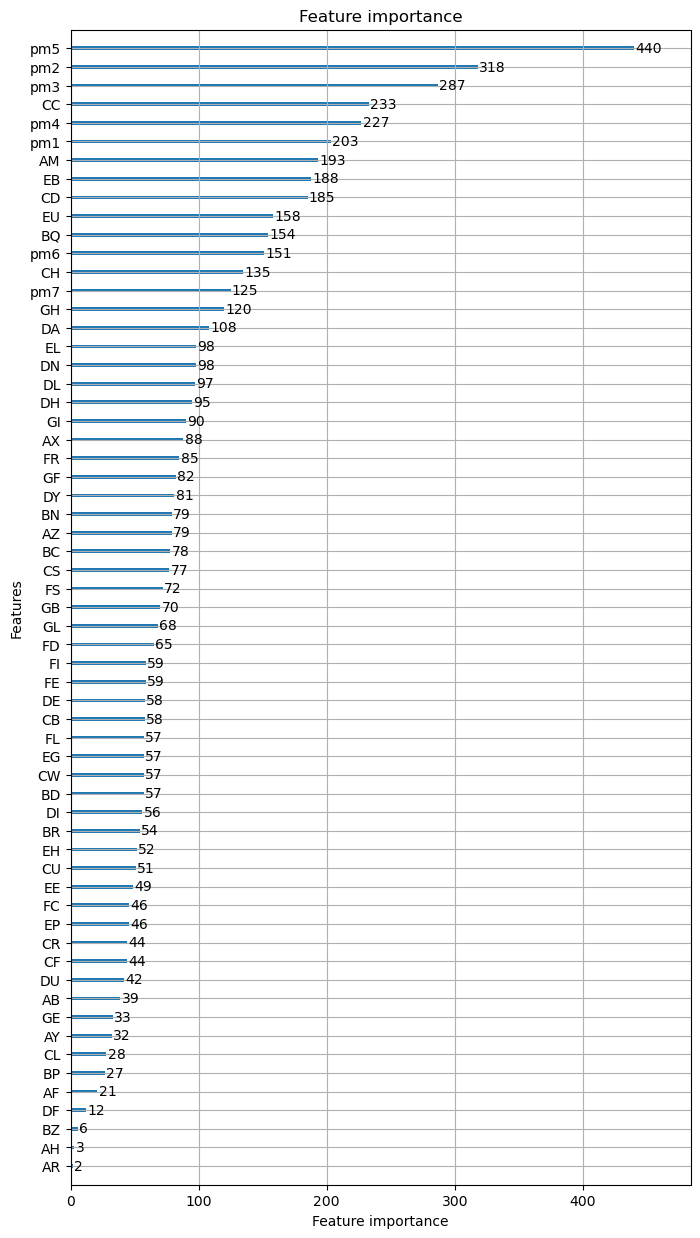

training model for fold: 4/5
[100]	valid_0's balanced_logloss: 0.461478


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's balanced_logloss: 0.295712
[300]	valid_0's balanced_logloss: 0.221138
[400]	valid_0's balanced_logloss: 0.180765
[500]	valid_0's balanced_logloss: 0.158761
[600]	valid_0's balanced_logloss: 0.144998
[700]	valid_0's balanced_logloss: 0.136438
[800]	valid_0's balanced_logloss: 0.132172
[900]	valid_0's balanced_logloss: 0.128966
[1000]	valid_0's balanced_logloss: 0.125718
[1100]	valid_0's balanced_logloss: 0.123868
[1200]	valid_0's balanced_logloss: 0.122157
[1300]	valid_0's balanced_logloss: 0.120972
[1400]	valid_0's balanced_logloss: 0.11981
[1500]	valid_0's balanced_logloss: 0.119468
[1600]	valid_0's balanced_logloss: 0.120389
[1700]	valid_0's balanced_logloss: 0.119583


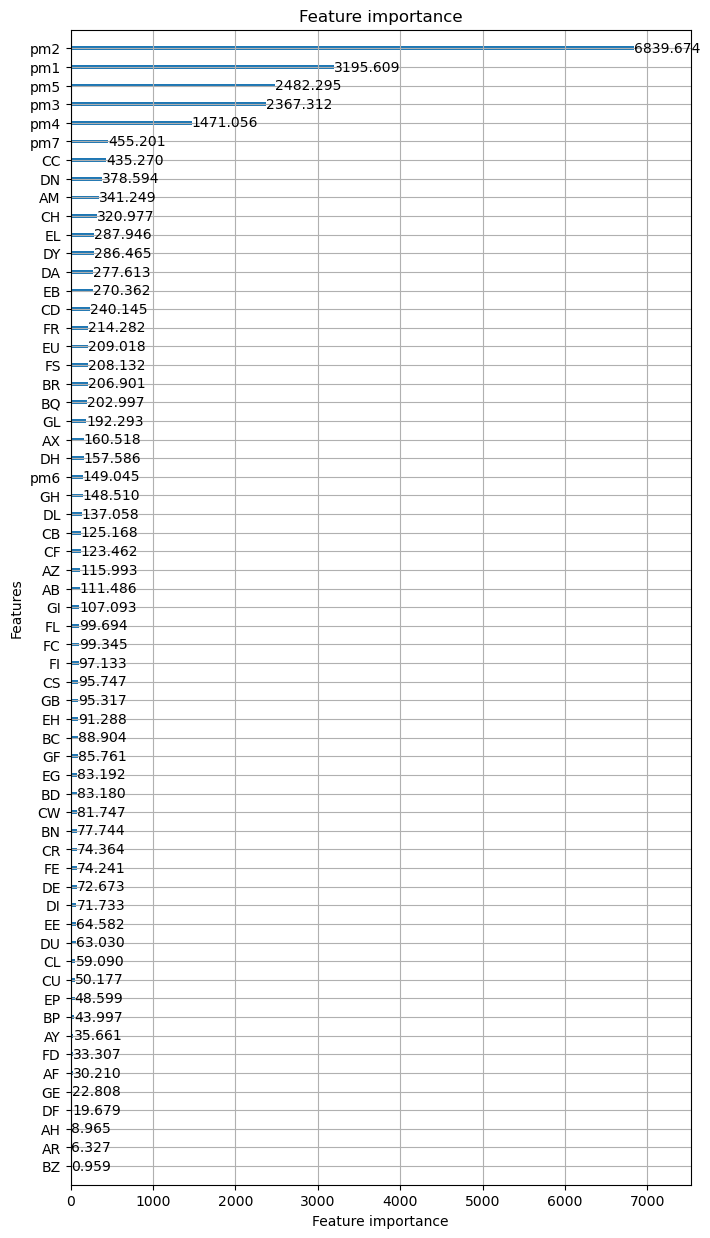

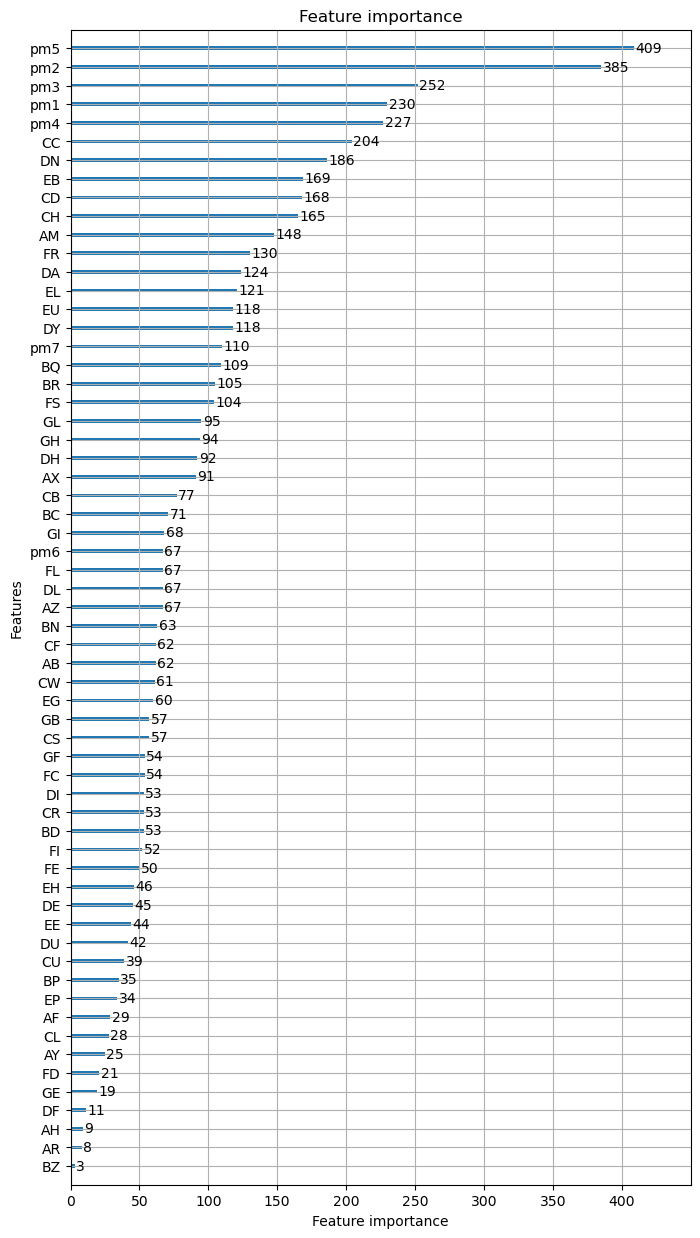

training model for fold: 5/5
[100]	valid_0's balanced_logloss: 0.515676


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	valid_0's balanced_logloss: 0.373906
[300]	valid_0's balanced_logloss: 0.311894
[400]	valid_0's balanced_logloss: 0.285509
[500]	valid_0's balanced_logloss: 0.277299
[600]	valid_0's balanced_logloss: 0.277408
[700]	valid_0's balanced_logloss: 0.279061
[800]	valid_0's balanced_logloss: 0.288481
[900]	valid_0's balanced_logloss: 0.295348
[1000]	valid_0's balanced_logloss: 0.304951
[1100]	valid_0's balanced_logloss: 0.312849
[1200]	valid_0's balanced_logloss: 0.324777
[1300]	valid_0's balanced_logloss: 0.339062
[1400]	valid_0's balanced_logloss: 0.349521
[1500]	valid_0's balanced_logloss: 0.354983
[1600]	valid_0's balanced_logloss: 0.363988
[1700]	valid_0's balanced_logloss: 0.376738


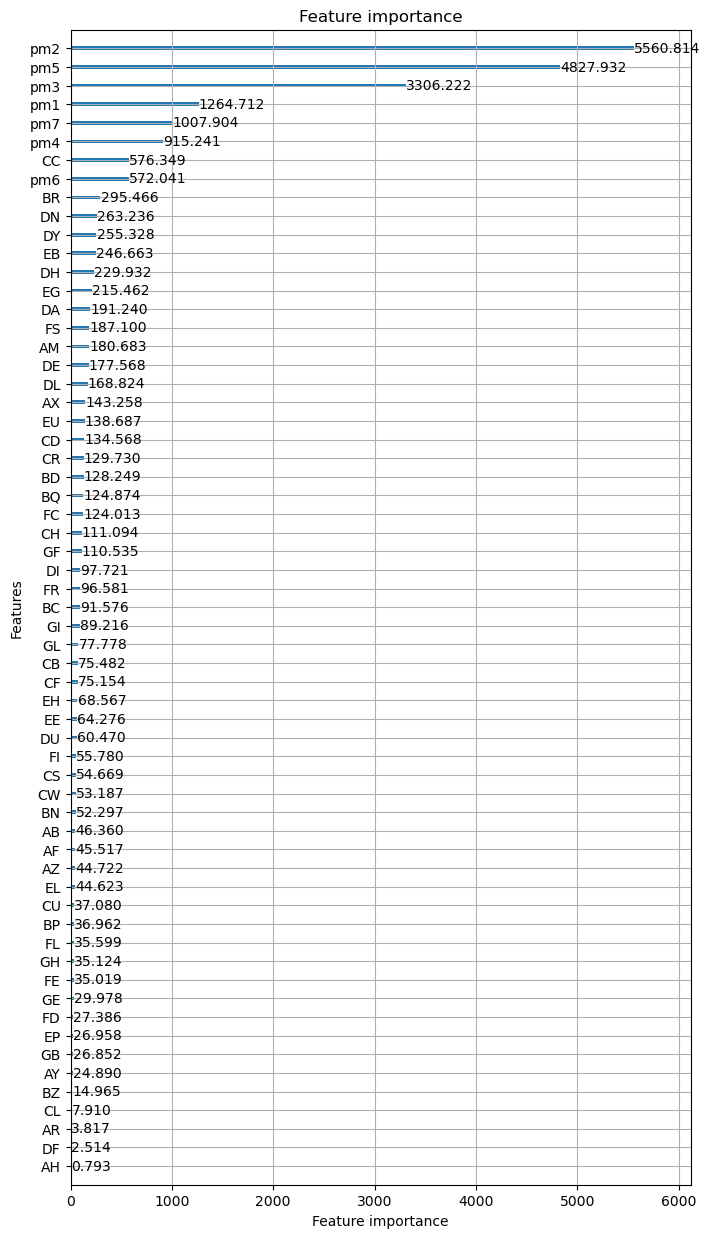

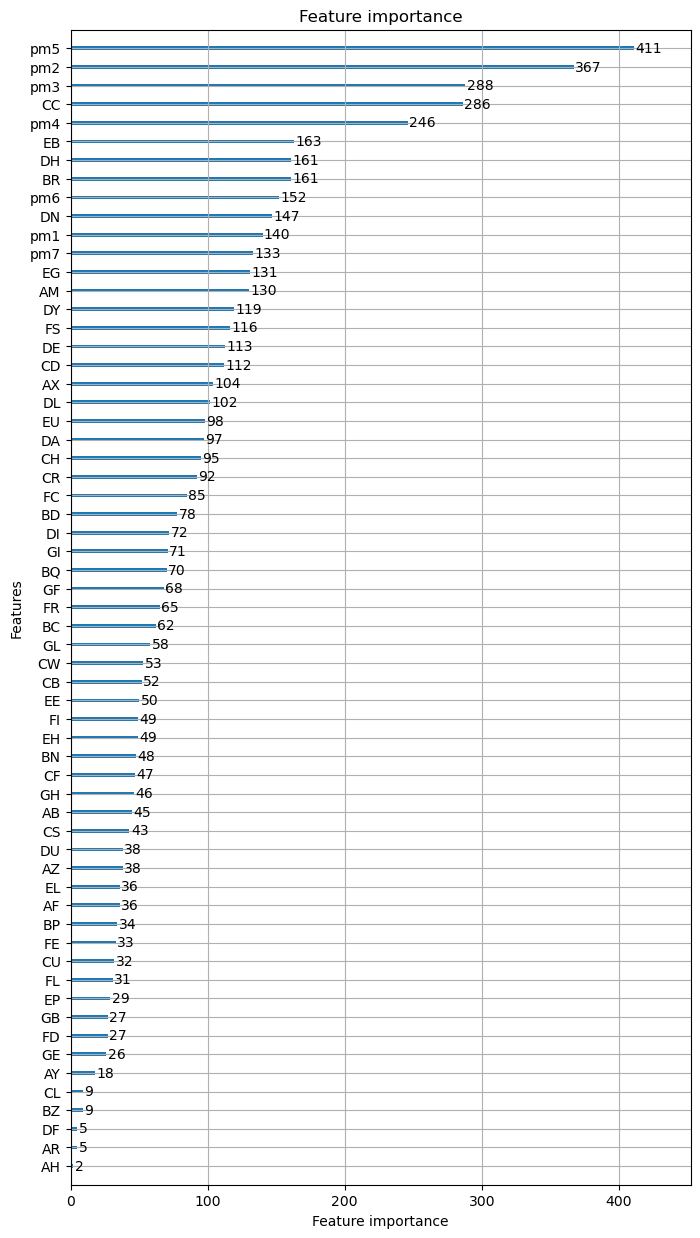

In [49]:
VERBOSE = True

models = list()
metrics = list()
oof_dfs = list()

for repeat in range(REPETITIONS):
    print(f"REPEAT NUMBER: {repeat+1}/{REPETITIONS}")
    cv_split = repeated_cv_split[f"repeat_{repeat}"]
    n_folds = len(cv_split)
    
    oof = train[["Id","Class"]].copy()
    oof["pred_proba"] = np.nan
    
    for split in cv_split:
        fold = split["fold"]
        train_idx = split["train_idx"]
        valid_idx = split["valid_idx"]
        print(f"training model for fold: {fold+1}/{n_folds}")
        
        _train,_input_cols = include_oof_preds(train, input_cols, oof_all, repeat)
    
        train_df = _train.loc[train_idx,:].reset_index(drop=True)
        valid_df = _train.loc[valid_idx,:].reset_index(drop=True)

        train_dset = lgb.Dataset(
            data=train_df.loc[:,_input_cols],
            label=train_df.loc[:,"Class"].values,
            free_raw_data=False
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,_input_cols],
            label=valid_df.loc[:,"Class"].values,
            free_raw_data=False
        )
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[balanced_logloss],
            callbacks=[lgb.log_evaluation(period=100),],
        )
        
        if VERBOSE:
            lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
            plt.show()
            lgb.plot_importance(model, importance_type="split", figsize=(8,15))
            plt.show()
            
        y_pred = model.predict(valid_df.loc[:,_input_cols])
        valid_loss = balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values)
        oof.loc[valid_idx, "pred_proba"] = y_pred
        
        models.append(model)
        metrics.append(valid_loss)
        
    break
        
    oof_dfs.append(oof)

In [41]:
np.mean(metrics)

0.3192228216013708

In [43]:
np.std(metrics)

0.17410301976285278

In [44]:
len(metrics)

50

In [ ]:
def compute_blend_metric(oof_all, weights):
    n_models = len(oof_all)
    n_repeats = 10
    size = len(oof_all[0][0])
   
    all_metrics = list()
    oof_dfs_blend = list()

    for repeat in range(n_repeats):
        pred_proba = np.zeros(size)
        target = oof_all[0][repeat].Class.values
        _oof = oof_all[0][repeat].copy(deep=True)

        for i in range(n_models):
            pred_proba += oof_all[i][repeat].pred_proba * weights[i]
            
        _oof["pred_proba"] = pred_proba    

        all_metrics.append(balanced_logloss_(pred_proba, target))
        oof_dfs_blend.append(_oof)

    return np.mean(all_metrics),oof_dfs_blend

def objective(oof_all, trial):
    
    n_models = len(oof_all)
    
    weights = np.array([
        trial.suggest_float(f"w_{i+1}", 0, 1)
        for i in range(n_models)
    ])
    weights /= weights.sum()
    
    return compute_blend_metric(oof_all, weights)[0]

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(
    direction='minimize',
)
study.optimize(
    partial(objective, oof_all), 
    n_trials=1000,
    n_jobs=1, 
    gc_after_trial=True,
)
print("best_value:", study.best_value)
print("best_params:", study.best_params)

In [ ]:
weights = np.array([study.best_params[f"w_{i+1}"] for i in range(len(oof_all))])
weights /= weights.sum()
print(weights)

In [ ]:
# sanity check
metric,oof_dfs_blend = compute_blend_metric(oof_all, weights)
metric

In [ ]:
# sanity check
compute_overall_metric(oof_dfs_blend)

In [ ]:
calib_params_blend = optimize_calibration(oof_dfs_blend)

In [ ]:
# sanity check
oof_dfs_calib_blend = calibrate_oof(oof_dfs_blend, calib_params_blend)
compute_overall_metric(oof_dfs_calib_blend)

***
# blend predictions

In [ ]:
predicted_probs_all = [
    predicted_probs_m01,
    predicted_probs_m02,
    predicted_probs_m03,
    predicted_probs_m04,
    predicted_probs_m05,
    predicted_probs_m06,
    predicted_probs_m07,
]

In [ ]:
predicted_probs_blend = np.zeros_like(predicted_probs_m01)
n_models = len(predicted_probs_all)

for i in range(n_models):
    predicted_probs_blend += predicted_probs_all[i]*weights[i] 

In [ ]:
predicted_probs_blend = calibrate_probs(predicted_probs_blend, **calib_params_blend)
predicted_probs_blend = np.clip(predicted_probs_blend, a_min=1e-7, a_max=1-1e-7)
predicted_probs_blend

In [ ]:
sub = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sub["class_0"] = 1-predicted_probs_blend
sub["class_1"] = predicted_probs_blend
sub.to_csv("submission.csv", index=False)
sub.describe()

***